<h2>Problem 1</h2>
<t>Inspired by the course example, train and validate a transformer model, for learning the above sequence. Use sequence lengths of 10, 20, and 30 for your training. Feel free to adjust other network parameters. Report and compare training loss, validation accuracy, execution time for training, and computational and mode size complexities against RNN-based approaches in Homework 3.</t>

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import time

import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

<h3>Tokenize Input Text and Create Dataset:</h3>

In [2]:
textPath = "C:/Users/aidan_000/Desktop/UNCC/Github/Intro-to-DL/datasets/text-sequences/nextchar.txt"

with open(textPath, "r", encoding='utf-8') as file:
    text = file.read()

# Grab unique characters from the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create dictionaries to map characters to integers and vice versa
charToIdx = {char: i for i, char in enumerate(chars)}
idxToChar = {i: char for char, i in charToIdx.items()}

encode = lambda string: [charToIdx[c] for c in string]
decode = lambda indices: ''.join([idxToChar[idx] for idx in indices])

encoded_text = encode(text)

# print(encode('test'))
# print(decode(encode('test')))

In [3]:
def prepare_data(encoded_text, sequence_len, k, batch_size):
    sequences, targets = [], []
    for i in range(0, len(encoded_text) - sequence_len[k]):
        sequence = encoded_text[i: i+sequence_len[k]]
        target = encoded_text[i+sequence_len[k]]

        sequences.append(sequence)
        targets.append(target)

    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    dataset = CharacterDataset(sequences, targets)

    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    #Create DataLoaders for train and test sets
    training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

    return training_loader, validation_loader

class CharacterDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

<h3>Model Training and Evaluation:</h3>

In [4]:
def train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval):
    
    training_losses = []
    validation_accuracies = []
    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_train = time.time()
        
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            train_output = model(inputs)
            train_loss = criterion(train_output, labels)
            running_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        
        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                valid_output = model(inputs)
                _, predicted = torch.max(valid_output, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        
            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - starting_time
            print('Epoch {:3d}, Time (secs) {:.2f}: Training loss {:.4f}, Validation Accuracy {:.2f}%'.format(epoch + 1, rounds_time, training_losses[-1], validation_accuracies[-1]))

    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')
    
    return training_losses, validation_accuracies, training_time, validation_time


# Prediction function
def charInference(model, initial_string, sequence_len, k):
    model.eval()
    with torch.no_grad():
        # Encode the initial string
        initial_input = torch.tensor([encode(initial_string[-sequence_len[k]:])], dtype=torch.long).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        
        # Decode the predicted index
        return decode([predicted_index])

<h3>Next Character Transformer</h3>

In [5]:
class OptimusTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(OptimusTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

<h3>Hyperparameters and Training</h3>

In [6]:
context_window = [10, 20, 30]

learning_rate = 0.001
epochs = 100

hidden_size = 256
num_layers = 3
nhead = 2


models = []
training_losses, validation_accuracies = [], []
training_times, validation_times = [], []

for k in range(len(context_window)):
    model = OptimusTransformer(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size, num_layers=num_layers, nhead=nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_loader, validation_loader = prepare_data(encoded_text, context_window, k, batch_size = 128)

    train_loss, valid_accuracy, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=10)
    
    models.append(model)

    training_losses.append(train_loss)
    validation_accuracies.append(valid_accuracy)
    
    training_times.append(training_time)
    validation_times.append(validation_time)

Epoch  10, Time (secs) 1.30: Training loss 1.5399, Validation Accuracy 33.12%
Epoch  20, Time (secs) 2.41: Training loss 0.7855, Validation Accuracy 33.12%
Epoch  30, Time (secs) 3.52: Training loss 0.5071, Validation Accuracy 31.45%
Epoch  40, Time (secs) 4.64: Training loss 0.4446, Validation Accuracy 32.08%
Epoch  50, Time (secs) 5.74: Training loss 0.3512, Validation Accuracy 31.24%
Epoch  60, Time (secs) 6.84: Training loss 0.3432, Validation Accuracy 30.82%
Epoch  70, Time (secs) 7.95: Training loss 0.2457, Validation Accuracy 31.24%
Epoch  80, Time (secs) 9.10: Training loss 0.2516, Validation Accuracy 32.70%
Epoch  90, Time (secs) 10.26: Training loss 0.2319, Validation Accuracy 31.66%
Epoch 100, Time (secs) 11.41: Training loss 0.2150, Validation Accuracy 33.33%

Total Duration: 11.41s
Training Duration: 0.10s
Inference Duration: 0.01s

Final Training Loss: 0.2150
Final Validation Accuracy: 33.33%
Epoch  10, Time (secs) 1.48: Training loss 1.9192, Validation Accuracy 27.58%
Ep

In [7]:
Model0_stats = summary(models[0], (context_window[0], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
Model1_stats = summary(models[1], (context_window[1], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
Model2_stats = summary(models[2], (context_window[2], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

print(f'\n========================================= Total Time per Model =========================================')
print(f'Model with Context of 10 Training Duration: {training_times[0]:.2f}s, Inference Duration: \t{validation_times[0]:.2f}s')
print(f'Model with Context of 20 Training Duration: {training_times[1]:.2f}s, Inference Duration: \t{validation_times[1]:.2f}s')
print(f'Model with Context of 30 Training Duration: {training_times[2]:.2f}s, Inference Duration: \t{validation_times[2]:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'Model with Context of 10  Training Loss: {training_losses[0][-1]:.4f}, Inference Accuracy: {validation_accuracies[0][-1]:.2f}%')
print(f'Model with Context of 20  Training Loss: {training_losses[1][-1]:.4f}, Inference Accuracy: {validation_accuracies[1][-1]:.2f}%')
print(f'Model with Context of 30  Training Loss: {training_losses[2][-1]:.4f}, Inference Accuracy: {validation_accuracies[2][-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                            Kernel Shape     Output Shape     Param #          Mult-Adds
OptimusTransformer (OptimusTransformer)            --               [10, 45]         --               --
├─Embedding (embedding)                            --               [10, 45, 256]    11,520           115,200
│    └─weight                                      [256, 45]                         └─11,520
├─TransformerEncoder (transformer_encoder)         --               [10, 45, 256]    --               --
│    └─layers.0.self_attn.in_proj_weight           [768, 256]                        ├─196,608
│    └─layers.0.self_attn.in_proj_bias             [768]                             ├─768
│    └─layers.0.self_attn.out_proj.weight          [256, 256]                        ├─65,536
│    └─layers.0.self_attn.out_proj.bias            [256]                             ├─256
│    └─layers.0.linear1.weight                     [2048, 256]                       ├─524,288
│    └─l

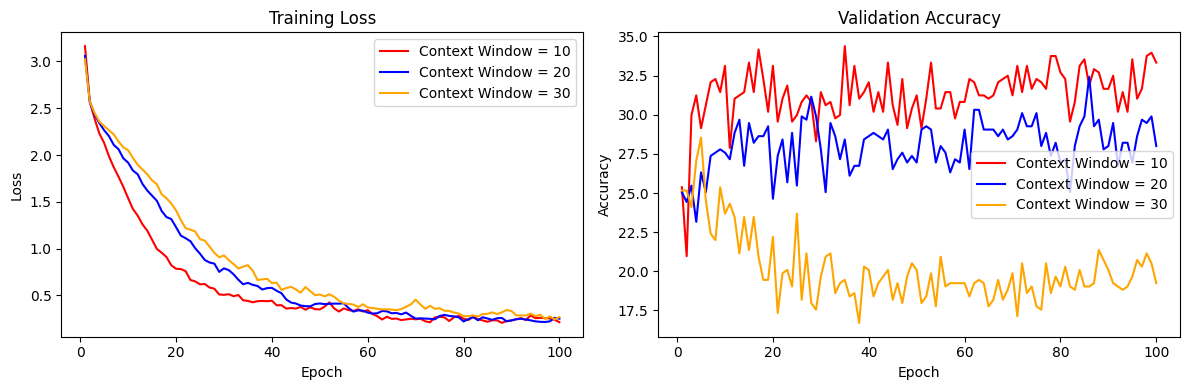

In [8]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses[0], label='Context Window = 10', color = 'red')
plt.plot(epochs_range, training_losses[1], label='Context Window = 20', color = 'blue')
plt.plot(epochs_range, training_losses[2], label='Context Window = 30', color = 'orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracies[0], label='Context Window = 10', color = 'red')
plt.plot(epochs_range, validation_accuracies[1], label='Context Window = 20', color = 'blue')
plt.plot(epochs_range, validation_accuracies[2], label='Context Window = 30', color = 'orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()